In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import ipywidgets as widgets
import seaborn as sns

sns.set_style("whitegrid")
import copy
import json
import pathlib
import pickle as pkl
from typing import Dict, List, Optional, Type

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from incremental_tasks import ID_TO_PRETTY_NAME, ID_TO_TASK, NAME_TO_ID
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import reservoir_ca
from reservoir_ca.datasets.imdb import IMDBTask
from reservoir_ca.decoders import ConvClassifier, ConvNetwork, OptType
from reservoir_ca.experiment import Experiment, ExpOptions, RegType, Reservoir
from reservoir_ca.reservoir import CAInput, CAReservoir, CARuleType, ProjectionType
from reservoir_ca.sequential_task import SequentialTasks
from reservoir_ca.tasks import (
    AdjectiveLanguage,
    BinarizedTask,
    ElementaryLanguage,
    ElementaryLanguageWithWorldDef,
    ElementaryLanguageWithWorldDefCounting,
    HarderElementaryLanguage,
    HardSymbolCounting,
    HybridTask,
    IncreasingPeriod,
    Periodic,
    RandomPeriodic,
    SymbolCounting,
)

name_to_id = NAME_TO_ID
name_to_id["imdb"] = 11

id_to_task = ID_TO_TASK
id_to_task[11] = IMDBTask

id_to_pretty_name = ID_TO_PRETTY_NAME
id_to_pretty_name[11] = "IMDB Task"


def make_ca_reservoir(
    ca_class: Type[CAReservoir], t: int, exp: Experiment, opts: ExpOptions
) -> Reservoir:
    ca = ca_class(
        t,
        exp.task.output_dimension(),
        redundancy=opts.redundancy,
        r_height=opts.r_height,
        proj_factor=opts.proj_factor,
        proj_type=opts.proj_type,
        proj_pattern=opts.proj_pattern,
    )
    if opts.ca_rule_type == CARuleType.WINPUTONCE and isinstance(ca, CAInput):
        ca.use_input_once = True
    return ca


def time_to(per, arr):
    v = arr > per
    return np.argmax(v, axis=-1) - np.bitwise_not(np.any(v, axis=1)).astype(int)


def get_data(rule, s) -> np.ndarray:
    """Returns an array of shape (n_runs, min_len)
    where n_runs is then number of separate arrays in s[rule] and
    min_len is the minimal length of these arrays.
    """
    t = min(len(k) for k in s[rule])
    base = np.array([u[:t] for u in s[rule]])
    return base


def compute_spread_ttos(
    vec, step=0.01, output_size: Optional[int] = None, factor: Optional[float] = None
) -> np.ndarray:
    if output_size is not None:
        rg = np.arange(1 / output_size, 1, step)
    else:
        rg = np.arange(0, 1, step)
    res = np.array([time_to(p, vec) for p in rg]).astype(float)

    if factor is not None:
        res[res > 0] /= factor
    return res, rg


def ode_metric(
    ttos,
    wg=10,
    do_sum=True,
    isbin=False,
    log=False,
    speed=False,
    step=0.01,
    output_size: Optional[int] = None,
):
    r = (ttos + 1).astype(float)
    r[r == 0] = np.inf

    if not speed:
        weight = np.zeros(r.shape[0])
        fn = np.linspace if not log else np.logspace
        if isbin:
            weight[-r.shape[0] // 2 + 1 :] += fn(1, wg, r.shape[0] // 2)
        else:
            weight[-r.shape[0] :] += fn(1, wg, r.shape[0])
        weight = weight[:, None]
        weight /= weight.sum()
        res = weight * (1 / r)
    else:
        if output_size is not None:
            inv = 1 / output_size
            rg = (np.arange(inv, 1, step) - inv) / (1 - inv)
        else:

            rg = np.arange(0, 1, step)
            # rg = np.ones_like(np.arange(0, 1, step))

        weight = rg
        res = weight[:, None] * 1 / r

    # range_vec = np.arange(0, 1, step)
    range_vec = weight
    if do_sum:
        return (res / weight[:, None].sum()).sum(0)
    else:
        return res, range_vec


def get_ttos(
    rule,
    s,
    inv_norm=True,
    do_sum=True,
    step=0.01,
    isbin=False,
    weight=10,
    log=False,
    speed=False,
    output_size: Optional[int] = None,
    factor: Optional[int] = None,
):
    base = get_data(rule, s)
    return get_ttos_from_data(
        base, inv_norm, do_sum, step, isbin, weight, log, speed, output_size, factor
    )


def get_ttos_from_data(
    base,
    inv_norm=True,
    do_sum=True,
    step=0.01,
    isbin=False,
    weight=10,
    log=False,
    speed=False,
    output_size: Optional[int] = None,
    factor: Optional[int] = None,
):
    ttos, rg = compute_spread_ttos(
        base, step=step, output_size=output_size, factor=factor
    )

    if inv_norm:
        if do_sum:
            return ode_metric(
                ttos,
                do_sum=do_sum,
                isbin=isbin,
                wg=weight,
                log=log,
                speed=speed,
                step=step,
                output_size=output_size,
            )
        else:
            return ode_metric(
                ttos,
                do_sum=do_sum,
                isbin=isbin,
                wg=weight,
                log=log,
                speed=speed,
                step=step,
                output_size=output_size,
            )
    else:
        return ttos


def mean_tto(tto):
    res = []
    for k in tto:
        n = np.sum(k > -1)
        if n > 0:
            res.append([np.mean(k[k > -1]), n / len(k)])
        else:
            res.append([-1, 0])
    return res


def best_tto(tto):
    res = []
    for k in tto:
        n = np.sum(k > -1)
        if n > 0:
            res.append(np.min(k[k > -1]))
        else:
            res.append(-1)
    return res


def numpy_ewma_vectorized(data, window):

    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha

    scale = 1 / alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev ** (r + 1)
    pw0 = alpha * alpha_rev ** (n - 1)

    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out

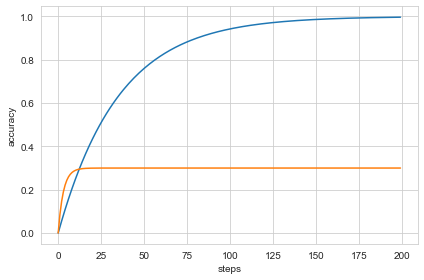

In [2]:
x = np.arange(200)
x0 = 1 - np.exp(-x / 35)
x1 = 0.3 * (1 - np.exp(-x / 3))
plt.plot(x0)
plt.plot(x1)
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.tight_layout()
plt.savefig("test.jpg")

In [3]:
print((x0[1:] - x0[:-1]).mean())
print((x1[1:] - x1[:-1]).mean())

0.005008069808941156
0.001507537688442211


In [4]:
time_to(0.2, x0[None, :])

array([8])

In [5]:
time_to(0.4, x0[None, :])

array([18])

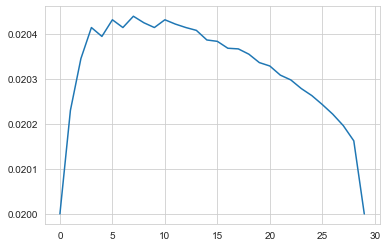

In [6]:
k = []
for t in np.linspace(0, 1, 30):
    tt = time_to(t, x0[None, :])
    if tt > 0:
        k.append(t / (1 + tt[0]))
    else:
        k.append(0)

k = np.array(k) + 1

k[k == np.inf] = 0
k = k / np.linspace(0, 1, 100).sum()
plt.plot(k)

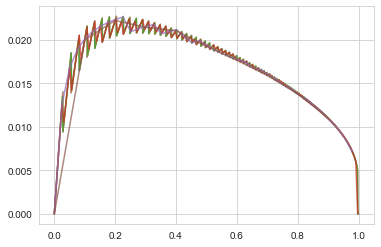

In [7]:
for step in np.logspace(-4, -1, 6):
    x, y = get_ttos_from_data(x0[None, :], do_sum=False, speed=True, step=step)

    plt.plot(y, x, alpha=0.7)

[0.03403831]
[0.01962554]


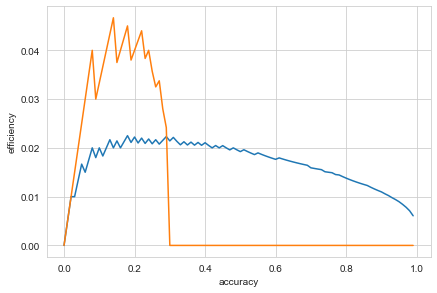

In [8]:
x, y = get_ttos_from_data(x0[None, :], do_sum=False, speed=True)
plt.plot(y, x)
x, y = get_ttos_from_data(x1[None, :], do_sum=False, speed=True)
plt.plot(y, x)
print(get_ttos_from_data(x0[None, :], do_sum=True, speed=True))
print(get_ttos_from_data(x1[None, :], do_sum=True, speed=True))
plt.tight_layout()
plt.xlabel("accuracy")
plt.ylabel("efficiency")
plt.savefig("test.jpg")

In [9]:
def get_speed(k):
    avg_speeds = []
    for i in s[r]:
        speed = np.array(i)[1:] - np.array(i)[:-1]
        avg_speeds.append(np.mean(speed))
    return np.array(avg_speeds)

In [10]:
def fusion_dict(base, dict_sup):
    if base:
        dt = set(base.keys())
        dt.update(dict_sup.keys())
        for k in dt:
            if k in base:
                if k in dict_sup:
                    base[k] = base[k] + dict_sup[k]
            else:
                base[k] = dict_sup[k]
        return base
    else:
        return dict_sup

In [22]:
bs_dict = pathlib.Path("../experiment_sgd")
result_dict = {}
tasks = {}
for sub in bs_dict.glob("*"):
    if sub.is_dir():
        print("Found task", sub.stem)
    else:
        continue
    tasks[sub.stem] = {}
    for f in sub.glob("*_tta.pkl"):
        if not sub.stem in result_dict:
            result_dict[sub.stem] = {}

        opt_path = f.parent / (
            f.stem.replace("_extra", "").replace("_tta", "") + ".json"
        )
        opts = ExpOptions.from_json(open(opt_path).read())
        if opts.proj_type == ProjectionType.ONE_TO_ONE:
            s = pkl.load(open(f, "rb"))
            # for k in [-2, -20, -200, -3, -30, -300, -4, -40, -400]:
            #    if k in s:
            #        s[k] = [numpy_ewma_vectorized(np.array(i), 50) for i in s[k]]

            result_dict[sub.stem] = fusion_dict(result_dict[sub.stem], s)

Found task qa-world-def
Found task periodic
Found task adj-qa-ct
Found task sym-ct
Found task hard-qa
Found task adj-qa
Found task qa
Found task qa-world-def-ct
Found task imdb
Found task inc-per
Found task hard-sym-ct


In [23]:
human = [1.0, 1.0, 0.109, 0.090, 0.150, 0.123, None, None, None, None, None]

In [93]:
def format_tto(mean, std) -> str:
    lstd = f"{std:.2f}"  # .lstrip("0")
    return f"{mean:.2f} ${{\scriptscriptstyle \\pm{lstd} }}$"

periodic
Max [135 161 149  30  45  86 101  89  22 126] [138  34 112  85 208 162 240  16 130 176]
Average [ 23 232 104 251 160  32 237  40  96 168] [176 112  85 170 162  42  15 240  48  34]
TTO [86, 149, 135, 101, 161, 75, 89, 30, 45, 126] [112, 190, 24, 231, 187, 152, 66, 189, 194, 34]
34 0.7805931082341747 Accuracy 0.9919422142119884
ESN 0.7377509848121921 Accuracy 0.995391753514153
RNN-2 0.3050952758746168 Accuracy 0.7906406409614384
RNN-20 0.3540375020685974 Accuracy 0.7798747814998507
RNN-3 0.2824299550961974 Accuracy 0.6757403881807887
RNN-30 0.2957682144322329 Accuracy 0.6800659051363367
RNN-4 0.30886590553590165 Accuracy 0.6881762147058933
RNN-40 0.3100993298499329 Accuracy 0.6931202441150919



inc-per
Max [ 30   0 128 165 169  55  43 236  29   5] [ 34 130   2 191   3  38 186  59  35 170]
Average [  0 128  55  63  30  31 160  32  40 168] [186 190 130   2 191 187  34  38  59  35]
TTO [30, 43, 165, 0, 128, 169, 60, 166, 234, 183] [32, 40, 160, 168, 235, -1, 28, 156, -2, 37]
35 0.

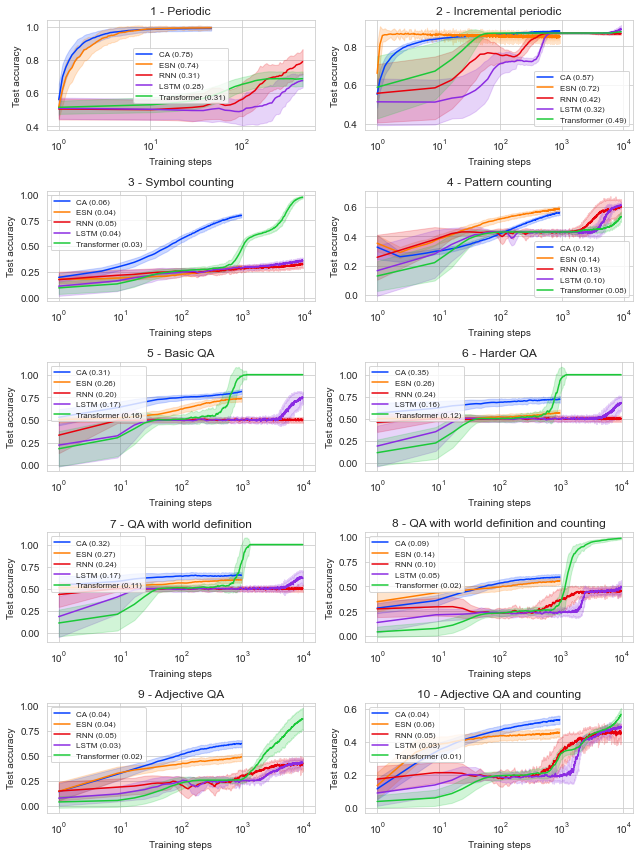

In [94]:
table = [
    "\\toprule",
    "& \\bfseries ReCA & \\bfseries ESN & \\bfseries RNN & \\bfseries LSTM & \\bfseries Transformer & \\bfseries Human expert \\\\",
    "\\midrule",
]

step = 0.001
weight = 1
speed = True
# fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ls = [
    "periodic",
    "inc-per",
    "sym-ct",
    "hard-sym-ct",
    "qa",
    "hard-qa",
    "qa-world-def",
    "qa-world-def-ct",
    "adj-qa",
    "adj-qa-ct",
    # "imdb",
]
# ls = ['periodic', 'sym-ct', 'hard-sym-ct', 'qa', 'hard-qa', 'qa-world-def','qa-world-def-ct','adj-qa', 'adj-qa-ct']
color = ["326ed0", "f3d155", "d1495b", "6bab90", "06bee1"]
color = [
    "%02x%02x%02x" % (int(255 * r), int(255 * g), int(255 * b))
    for (r, g, b) in sns.color_palette("bright")
]

fig = plt.figure(figsize=(9, 12))

### Prepare a matplotlib grid with the right size
gs0 = gridspec.GridSpec(len(ls) // 2 + len(ls) % 2, 2, figure=fig)

batch_size = 8
c = 0
for ts_num, name in enumerate(ls):
    print(name)
    output_size = ID_TO_TASK[NAME_TO_ID[name]]().get_true_output_size()
    output_size = np.inf
    n_items_per_seq = ID_TO_TASK[NAME_TO_ID[name]]().get_n_items_per_seq()
    task_title = f"{NAME_TO_ID[name]} - {ID_TO_PRETTY_NAME[NAME_TO_ID[name]]}"
    s = result_dict[name]
    # In case all the data hasn't been generated yet.
    # if all(x < 0 for x in s.keys()):
    #    s[0] = [np.zeros(100)]

    rules = np.array([k for k in range(256) if k in s])
    rules_max = np.array([max([max(i) for i in s[k]]) for k in range(256) if k in s])
    sorted_rules_max = np.argsort(rules_max)
    print("Max", rules[sorted_rules_max[:10]], rules[sorted_rules_max[-10:]])

    rules_mean = np.array(
        [np.mean([max(i) for i in s[k]]) for k in range(256) if k in s]
    )
    sorted_rules_mean = np.argsort(rules_mean)
    print("Average", rules[sorted_rules_mean[:10]], rules[sorted_rules_mean[-10:]])
    if sorted_rules_mean.size > 0:
        rule = rules[sorted_rules_mean[-1]]
    else:
        rule = None

    ###### Rules sorted by TTO
    all_ttos = [
        (
            r,
            get_ttos(
                r,
                s,
                speed=speed,
                output_size=output_size,
                factor=n_items_per_seq / batch_size,
            ).max(),
        )
        for r in range(-2, 256)
        if r in s
    ]
    sorted_rules_tto = [i[0] for i in sorted(all_ttos, key=lambda x: x[1])]
    print("TTO", sorted_rules_tto[:10], sorted_rules_tto[-10:])

    ###### ReCA TTO score
    r_tto = 0
    if rule is not None:
        tto = get_ttos(
            rule,
            s,
            speed=speed,
            output_size=output_size,
            factor=n_items_per_seq / batch_size,
        )
        r_tto = tto.mean()
        s_tto = tto.std()
        t_reca = min(len(k) for k in s[rule])
        tasks[name]["ReCA"] = np.array([k[:t_reca] for k in s[rule]])
        print(rule, r_tto, "Accuracy", tasks[name]["ReCA"].mean(0).max())

    ###### Echo state network TTO score
    esn_tto = 0
    if -1 in s:
        tto = get_ttos(
            -1,
            s,
            speed=speed,
            output_size=output_size,
            factor=n_items_per_seq / batch_size,
        )
        esn_tto = tto.mean()
        esns_tto = tto.std()
        t = min(len(k) for k in s[-1])
        tasks[name]["ESN"] = np.array([k[:t] for k in s[-1]])
    print("ESN", esn_tto, "Accuracy", tasks[name]["ESN"].mean(0).max())

    ###### RNN TTO score
    rnn_tto = {}
    rnns_tto = {}
    for k in [-2, -20, -200, -3, -30, -4, -40]:
        if k in s:
            tto = get_ttos(k, s, speed=speed, output_size=output_size)
            rnn_tto[k] = tto.mean()
            rnns_tto[k] = tto.std()
            t = min(len(p) for p in s[k])
            tasks[name][f"RNN{k}"] = np.array([p[:t] for p in s[k]])
            print(
                f"RNN{k}", rnn_tto[k], "Accuracy", tasks[name][f"RNN{k}"].mean(0).max()
            )

    v = 5 * [""]
    vals = [r_tto, esn_tto, rnn_tto.get(-2, 0), rnn_tto.get(-3, 0)]
    v[np.argmax(vals)] = "\\bfseries"

    human_score = f"{human[ts_num]:.2f}" if human[ts_num] is not None else "---"
    if task_title == "5 - Basic QA":
        task_title_table = "5 - Basic question answering (QA)"
    else:
        task_title_table = task_title
    table.append(
        f"\\bfseries {task_title_table} & {v[0]} {format_tto(r_tto, s_tto)}"
        f" & {v[1]} {format_tto(esn_tto, esns_tto)} & "
        f"{v[2]} {format_tto(rnn_tto.get(-2, 0), rnns_tto.get(-2, 0))} & {v[3]} "
        f"{format_tto(rnn_tto.get(-3, 0), rnns_tto.get(-3, 0))} "
        f" & {v[4]} {format_tto(rnn_tto.get(-4, 0), rnns_tto.get(-4, 0))}"
        f"& {human_score} \\\\"
    )
    print("\n\n")

    ax_x = c // 4
    ax_y = c % 4
    # plt.plot(s[rule][-1])
    gssub = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[c])
    ax0 = fig.add_subplot(gssub[0])
    # ax1 = fig.add_subplot(gssub[1])

    ax_right = fig.add_subplot(gssub[:])
    ax_right.axis("off")
    ax_right.set_title(task_title)
    # ======================== Plot learning curves =====================

    ###### Plot ReCA curve
    if rule is not None:
        blue = f"#{color[0]}"
        base = tasks[name]["ReCA"]
        x_axis = np.linspace(
            1, 1 + len(base[0]) * batch_size / n_items_per_seq, len(base[0])
        )
        ax0.fill_between(
            x_axis,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color=blue,
        )
        ax0.plot(x_axis, base.mean(0), label=f"CA ({r_tto:.2f})", color=blue)

    ###### Plot ESN curve
    if -1 in s:
        green = f"#{color[1]}"
        base = tasks[name]["ESN"]
        x_axis = np.linspace(
            1, 1 + len(base[0]) * batch_size / n_items_per_seq, len(base[0])
        )
        ax0.fill_between(
            x_axis,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color=green,
        )
        ax0.plot(x_axis, base.mean(0), label=f"ESN ({esn_tto:.2f})", color=green)

    ###### Plot RNN curve
    if "RNN-2" in tasks[name]:
        orange = f"#{color[3]}"
        base = tasks[name]["RNN-2"]
        x_axis_rnn = np.linspace(1, x_axis.max() * 10, len(base[0]))
        ax0.fill_between(
            x_axis_rnn,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color=orange,
        )
        ax0.plot(
            x_axis_rnn,
            base.mean(0),
            label=f"RNN ({rnn_tto.get(-2, 0):.2f})",
            color=orange,
        )

    ###### Plot LSTM curve
    if "RNN-3" in tasks[name]:
        cyan = f"#{color[4]}"
        base = tasks[name]["RNN-3"]
        x_axis_lstm = np.linspace(1, x_axis.max() * 10, len(base[0]))
        ax0.fill_between(
            x_axis_lstm,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color=cyan,
        )
        ax0.plot(
            x_axis_lstm,
            base.mean(0),
            label=f"LSTM ({rnn_tto.get(-3, 0):.2f})",
            color=cyan,
        )

    ###### Plot LSTM curve
    if "RNN-4" in tasks[name]:
        yellow = f"#{color[2]}"
        base = tasks[name]["RNN-4"]
        x_axis_lstm = np.linspace(1, x_axis.max() * 10, len(base[0]))
        ax0.fill_between(
            x_axis_lstm,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color=yellow,
        )
        ax0.plot(
            x_axis_lstm,
            base.mean(0),
            label=f"Transformer ({rnn_tto.get(-4, 0):.2f})",
            color=yellow,
        )

    ax0.set_xscale("log")

    #     res_ttos, rg = get_ttos(rule, s, do_sum=False, step=step, weight=weight,
    #                             speed=speed, output_size=output_size, factor=n_items_per_seq)
    #     #ax1.bar(x=rg + step/6, height=res_ttos.mean(1),
    #     #           width=1 * step/3, color="blue")
    #     ax1.fill_between(rg, np.zeros_like(res_ttos.mean(1)), res_ttos.mean(1), color="blue", alpha=0.3)

    #     if -1 in s:
    #         rnn_ttos, rg = get_ttos(-1, s, do_sum=False, step=step, weight=weight, speed=speed,
    #                                 output_size=output_size, factor=n_items_per_seq)
    #         #ax1.bar(x=rg - step/6, height=rnn_ttos.mean(1),
    #          #          width=1 * step/3, color="green")
    #         ax1.fill_between(rg, np.zeros_like(rnn_ttos.mean(1)),rnn_ttos.mean(1), color="green", alpha=0.3)

    #     if -20 in s:
    #         rnn_bs_ttos, rg = get_ttos(-20, s, do_sum=False, step=step, weight=weight,
    #                                    speed=speed, output_size=output_size)
    #         #ax1.bar(x=rg - step/6, height=rnn_ttos.mean(1),
    #          #          width=1 * step/3, color="green")
    #         ax1.fill_between(rg, np.zeros_like(rnn_bs_ttos.mean(1)),rnn_bs_ttos.mean(1), color="orange", alpha=0.3)

    #     choice = base[np.random.choice(range(len(base)))]
    #     ax1.set_xlabel("Accuracy")
    #     ax1.set_ylabel("Data efficiency")
    #     ax0.set_xlabel("Steps")
    #     ax0.set_ylabel("Accuracy")
    #     #plt.plot(choice, color="green", alpha=0.2) # , label="ESN - random run"
    #     #plt.plot(np.maximum.accumulate(choice), color="green", label=f"ESN - random run (+max)")
    #     #plt.plot(s[-1][np.argmax(get_ttos(-1, s))], color="darkgreen", label=f"ESN - best run TTO")
    #     # base = get_data(-2, s)
    #     # plt.fill_between(range(len(base[0])), base.mean(0) - base.std(0), base.mean(0) + base.std(0), alpha=0.3)
    #     # plt.plot(base.mean(0), label="RNN average")

    #     # plt.plot(base[np.random.choice(range(len(base)))], label=f"RNN - random run", color="red")
    ax0.set_xlabel("Training steps")
    ax0.set_ylabel("Test accuracy")
    ax0.legend(prop={"size": 8})

    c += 1
gs0.tight_layout(fig)
plt.show()

table.append("\\bottomrule")
fig.savefig("/Users/hugo/Work/papers/collas2022/figures/all_metrics_new.pdf")

In [96]:
mean_accs = dict(
    [
        (name, dict([(c, tasks[name][c].mean(0).max()) for c in tasks[name]]))
        for name in tasks
    ]
)
std_accs = dict(
    [
        (name, dict([(c, tasks[name][c].std(0)[-1]) for c in tasks[name]]))
        for name in tasks
    ]
)

acc_table = []
for ts_num, name in enumerate(ls):
    print(name)
    task_title = f"{NAME_TO_ID[name]} - {ID_TO_PRETTY_NAME[NAME_TO_ID[name]]}"

    task_accs = mean_accs[name]
    task_std = std_accs[name]
    num = {}
    max_mod = None
    max_acc = 0
    for t in ["ReCA", "ESN", "RNN-2", "RNN-3", "RNN-4"]:
        num[t] = f"{task_accs[t]:.2f} ${{\\scriptscriptstyle \\pm {task_std[t]:.2f}}}$"
        if task_accs[t] > max_acc:
            max_acc = task_accs[t]
            max_mod = t
    num[max_mod] = "\\bfseries " + num[max_mod]
        
    line = f"\\bfseries {task_title} & " + " & ".join(num.values()) + "  \\\\"
    acc_table.append(line)

periodic
inc-per
sym-ct
hard-sym-ct
qa
hard-qa
qa-world-def
qa-world-def-ct
adj-qa
adj-qa-ct


In [97]:
print("\n".join(acc_table).replace("and", "\&").replace("definition", "def."))

\bfseries 1 - Periodic & 0.99 ${\scriptscriptstyle \pm 0.01}$ & \bfseries 1.00 ${\scriptscriptstyle \pm 0.01}$ & 0.79 ${\scriptscriptstyle \pm 0.08}$ & 0.68 ${\scriptscriptstyle \pm 0.04}$ & 0.69 ${\scriptscriptstyle \pm 0.04}$  \\
\bfseries 2 - Incremental periodic & 0.88 ${\scriptscriptstyle \pm 0.01}$ & 0.87 ${\scriptscriptstyle \pm 0.03}$ & 0.87 ${\scriptscriptstyle \pm 0.00}$ & \bfseries 0.89 ${\scriptscriptstyle \pm 0.02}$ & 0.88 ${\scriptscriptstyle \pm 0.00}$  \\
\bfseries 3 - Symbol counting & 0.80 ${\scriptscriptstyle \pm 0.02}$ & 0.30 ${\scriptscriptstyle \pm 0.02}$ & 0.33 ${\scriptscriptstyle \pm 0.03}$ & 0.36 ${\scriptscriptstyle \pm 0.03}$ & \bfseries 0.97 ${\scriptscriptstyle \pm 0.01}$  \\
\bfseries 4 - Pattern counting & 0.56 ${\scriptscriptstyle \pm 0.01}$ & 0.59 ${\scriptscriptstyle \pm 0.02}$ & 0.61 ${\scriptscriptstyle \pm 0.05}$ & \bfseries 0.61 ${\scriptscriptstyle \pm 0.02}$ & 0.54 ${\scriptscriptstyle \pm 0.03}$  \\
\bfseries 5 - Basic QA & 0.81 ${\scriptscript

In [98]:
print("\n".join(table).replace("and", "\&").replace("definition", "def."))

\toprule
& \bfseries ReCA & \bfseries ESN & \bfseries RNN & \bfseries LSTM & \bfseries Transformer & \bfseries Human expert \\
\midrule
\bfseries 1 - Periodic & \bfseries 0.78 ${\scriptscriptstyle \pm0.05 }$ &  0.74 ${\scriptscriptstyle \pm0.05 }$ &  0.31 ${\scriptscriptstyle \pm0.06 }$ &  0.28 ${\scriptscriptstyle \pm0.07 }$  &  0.31 ${\scriptscriptstyle \pm0.04 }$& 1.00 \\
\bfseries 2 - Incremental periodic &  0.57 ${\scriptscriptstyle \pm0.02 }$ & \bfseries 0.72 ${\scriptscriptstyle \pm0.02 }$ &  0.42 ${\scriptscriptstyle \pm0.16 }$ &  0.32 ${\scriptscriptstyle \pm0.11 }$  &  0.49 ${\scriptscriptstyle \pm0.15 }$& 1.00 \\
\bfseries 3 - Symbol counting & \bfseries 0.06 ${\scriptscriptstyle \pm0.01 }$ &  0.04 ${\scriptscriptstyle \pm0.01 }$ &  0.05 ${\scriptscriptstyle \pm0.02 }$ &  0.04 ${\scriptscriptstyle \pm0.02 }$  &  0.03 ${\scriptscriptstyle \pm0.01 }$& 0.11 \\
\bfseries 4 - Pattern counting &  0.12 ${\scriptscriptstyle \pm0.04 }$ & \bfseries 0.14 ${\scriptscriptstyle \pm0.03 }$

In [53]:
s = pkl.load(open("../experiment_sgd/periodic/periodic_extra_937a50d9_tta.pkl", "rb"))
if -1 in s:
    print(max([max(i) for i in s[-1]]))

if -2 in s:
    print(len(s[-2][-1]))
    plt.plot(s[-2][-1])
    # plt.plot(s[-2][0][:100])

0.9816345270890725


In [166]:
s.keys()

dict_keys([-2, -3, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [167]:
all_speeds = {}
for r, k in s.items():
    all_speeds[r] = np.mean(get_speed(k))
sorted_speeds = sorted(all_speeds.items(), key=lambda x: x[1])

In [168]:
sorted_scores = np.sort([max([max(i) for i in s[k]]) for k in range(256)])
sorted_scores[:10], sorted_scores[-10:]

(array([0.2155477 , 0.21715328, 0.21777003, 0.22262774, 0.22393162,
        0.22393162, 0.22393162, 0.22413793, 0.22473868, 0.23498233]),
 array([0.58965517, 0.59233449, 0.59233449, 0.59322034, 0.59717314,
        0.59724613, 0.59967585, 0.59967585, 0.6       , 0.6       ]))

[(222, 0.0013973296587288348),
 (132, 0.001400692876143004),
 (223, 0.001403699579878693),
 (4, 0.0014064346693304823),
 (228, 0.0014112924067190599),
 (217, 0.0014127774121398162),
 (100, 0.0014127811352943906),
 (203, 0.0014139855133929072),
 (44, 0.0014141098150910953),
 (172, 0.0014143414716187924)]

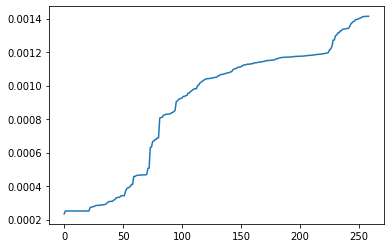

In [169]:
plt.plot([i[1] for i in sorted_speeds])
sorted_speeds[-10:]

[129, 126, 101, 75, 30, 149, 45, 22, 89, 135]
[247, 219, 36, 66, 189, 191, 130, 194, 2, -1]


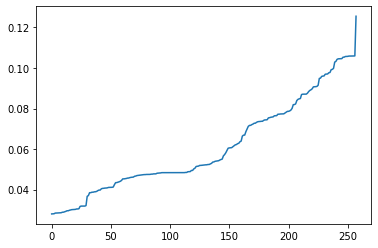

In [170]:
all_ttos = [(r, get_ttos(r, s).mean()) for r in range(-2, 256) if r in s]
sorted_rules = [i[0] for i in sorted(all_ttos, key=lambda x: x[1])]
plt.plot(np.sort([s[1] for s in all_ttos]))
print(sorted_rules[:10])
print(sorted_rules[-10:])

In [171]:
rule = 34
print(get_ttos(rule, s).mean())
print(get_ttos(37, s).mean())
if -1 in s:
    print(get_ttos(-1, s).mean())

0.10426704104306933
0.04748919026918428
0.12553448344389057


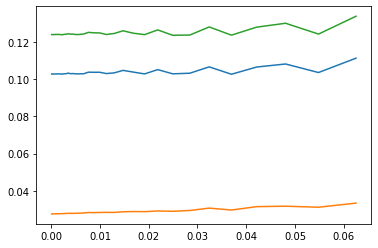

In [172]:
sp = np.logspace(-4, -1.2039728, 50)
plt.plot(sp, [get_ttos(rule, s, step=i).mean() for i in sp])
plt.plot(sp, [get_ttos(30, s, step=i).mean() for i in sp])
plt.plot(sp, [get_ttos(-1, s, step=i).mean() for i in sp])

[]

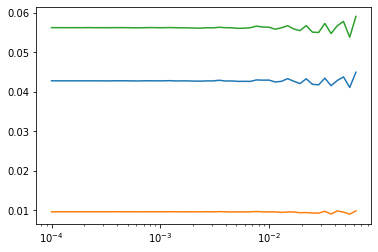

In [173]:
sp = np.logspace(-4, -1.2039728, 50)
plt.plot(
    sp,
    [
        get_ttos(
            rule,
            s,
            step=i,
            speed=speed,
            output_size=output_size,
            factor=n_items_per_seq,
        ).mean()
        for i in sp
    ],
)
plt.plot(
    sp,
    [
        get_ttos(
            30, s, step=i, speed=speed, output_size=output_size, factor=n_items_per_seq
        ).mean()
        for i in sp
    ],
)
plt.plot(
    sp,
    [
        get_ttos(
            -1, s, step=i, speed=speed, output_size=output_size, factor=n_items_per_seq
        ).mean()
        for i in sp
    ],
)
plt.semilogx()

(array([ 2.45716724,  0.        , 14.74300345,  9.82866897, 14.74300345,
        14.74300345, 24.57167241,  9.82866897, 12.28583621,  9.82866897,
         9.82866897, 24.57167241, 22.11450517,  4.91433448, 12.28583621,
        12.28583621,  7.37150172,  4.91433448,  2.45716724,  9.82866897]),
 array([0.07104433, 0.07551656, 0.07998879, 0.08446101, 0.08893324,
        0.09340547, 0.0978777 , 0.10234992, 0.10682215, 0.11129438,
        0.11576661, 0.12023883, 0.12471106, 0.12918329, 0.13365552,
        0.13812774, 0.14259997, 0.1470722 , 0.15154443, 0.15601665,
        0.16048888]),
 <BarContainer object of 20 artists>)

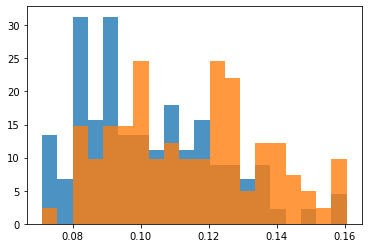

In [69]:
_, bins, _ = plt.hist(get_ttos(rule, s), alpha=0.8, bins=20, density=True)
plt.hist(get_ttos(-1, s), alpha=0.8, bins=bins, density=True)

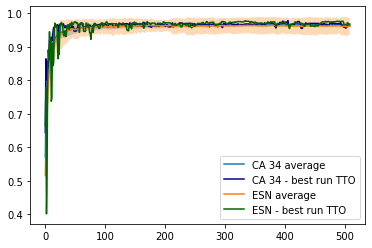

In [698]:
base = get_data(rule, s)
plt.fill_between(
    range(len(base[0])),
    base.mean(0) - base.std(0),
    base.mean(0) + base.std(0),
    alpha=0.3,
)
plt.plot(base.mean(0), label=f"CA {rule} average")

choice = base[np.random.choice(range(len(base)))]
# plt.plot(choice, color="blue", alpha=0.2) #, label=f"CA {rule} - random run"
# plt.plot(np.maximum.accumulate(choice), color="blue", label=f"CA {rule} - random run (+max)")
# plt.plot(base[np.random.choice(range(len(base)))])
plt.plot(
    s[rule][np.argmax(get_ttos(rule, s))],
    color="darkblue",
    label=f"CA {rule} - best run TTO",
)

base = get_data(-1, s)
plt.fill_between(
    range(len(base[0])),
    base.mean(0) - base.std(0),
    base.mean(0) + base.std(0),
    alpha=0.3,
)
plt.plot(base.mean(0), label="ESN average")

choice = base[np.random.choice(range(len(base)))]
# plt.plot(choice, color="green", alpha=0.2) # , label="ESN - random run"
# plt.plot(np.maximum.accumulate(choice), color="green", label=f"ESN - random run (+max)")
plt.plot(
    s[-1][np.argmax(get_ttos(-1, s))], color="darkgreen", label=f"ESN - best run TTO"
)
# base = get_data(-2, s)
# plt.fill_between(range(len(base[0])), base.mean(0) - base.std(0), base.mean(0) + base.std(0), alpha=0.3)
# plt.plot(base.mean(0), label="RNN average")

# plt.plot(base[np.random.choice(range(len(base)))], label=f"RNN - random run", color="red")
plt.legend()

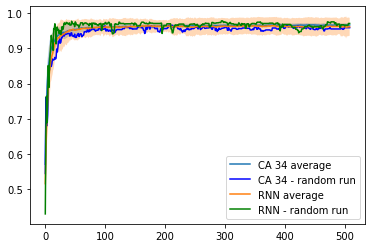

In [699]:
base = get_data(rule, s)
plt.fill_between(
    range(len(base[0])),
    base.mean(0) - base.std(0),
    base.mean(0) + base.std(0),
    alpha=0.3,
)
plt.plot(base.mean(0), label=f"CA {rule} average")

plt.plot(
    base[np.random.choice(range(len(base)))],
    label=f"CA {rule} - random run",
    color="blue",
)
# plt.plot(base[np.random.choice(range(len(base)))])
base = get_data(-1, s)
plt.fill_between(
    range(len(base[0])),
    base.mean(0) - base.std(0),
    base.mean(0) + base.std(0),
    alpha=0.3,
)
plt.plot(base.mean(0), label="RNN average")

plt.plot(
    base[np.random.choice(range(len(base)))], label=f"RNN - random run", color="green"
)
plt.legend()

0.058771994142138295
0.03470800417483203


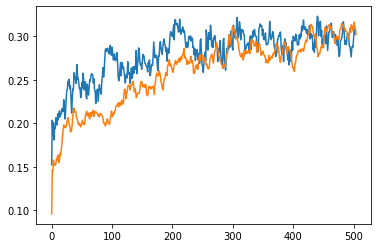

In [700]:
per = SymbolCounting([10])
opts = ExpOptions()
opts.redundancy = 32
opts.reg_type = RegType.SGDCLS
opts.max_n_seq = 5000
# opts.proj_type = ProjectionType.REWRITE

exp = Experiment(per, opts)
ca = make_ca_reservoir(CAReservoir, rule, exp, opts)

exp.set_reservoir(ca)
# masked_returned, msk = exp.fit(return_data=True)
partial_test_results = exp.fit_with_eval()

print(ode_metric(compute_spread_ttos(np.array(partial_test_results)[None, :])).mean())

opts.reg_type = RegType.ADAMCLS

exp2 = Experiment(per, opts)
ca = make_ca_reservoir(CAReservoir, rule, exp, opts)

exp2.set_reservoir(ca)
# masked_returned, msk = exp.fit(return_data=True)
plt.plot(partial_test_results)
partial_test_results = exp2.fit_with_eval()
plt.plot(partial_test_results)
print(ode_metric(compute_spread_ttos(np.array(partial_test_results)[None, :])).mean())

0.053131008517338804
0.06210601012280584


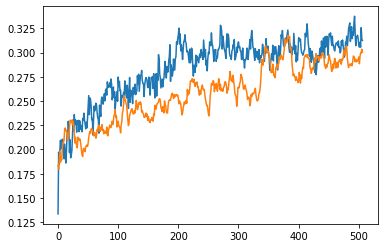

In [701]:
per = SymbolCounting([10])
opts = ExpOptions()
opts.redundancy = 32
opts.reg_type = RegType.SGDCLS
opts.max_n_seq = 5000
# opts.proj_type = ProjectionType.REWRITE

exp = Experiment(per, opts)
ca = make_ca_reservoir(CAReservoir, rule, exp, opts)

exp.set_reservoir(ca)
# masked_returned, msk = exp.fit(return_data=True)
partial_test_results = exp.fit_with_eval()

print(ode_metric(compute_spread_ttos(np.array(partial_test_results)[None, :])).mean())

opts.reg_type = RegType.ADAMCLS

exp2 = Experiment(per, opts)
ca = make_ca_reservoir(CAReservoir, rule, exp, opts)

exp2.set_reservoir(ca)
# masked_returned, msk = exp.fit(return_data=True)
plt.plot(partial_test_results)
partial_test_results = exp2.fit_with_eval()
plt.plot(partial_test_results)
print(ode_metric(compute_spread_ttos(np.array(partial_test_results)[None, :])).mean())

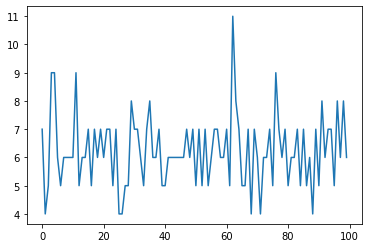

In [702]:
plt.plot(exp.predict_test(return_target=True)[0][300:400])

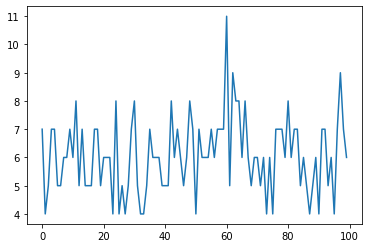

In [703]:
plt.plot(exp.predict_test(return_target=True)[1][300:400])

In [704]:
np.mean(
    exp2.predict_test(return_target=True)[1] == exp2.predict_test(return_target=True)[0]
)

0.30054917623564653

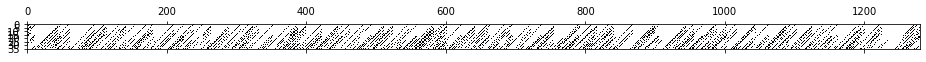

In [705]:
win_opts = copy.deepcopy(opts)
win_opts.ignore_mask = True
exp = Experiment(per, exp_options=win_opts)
exp.set_reservoir(ca)
data, _ = exp.fit(return_data=True)
data = data[-1]
plt.matshow(data[np.random.choice(range(len(data)))], cmap="Greys")

periodic
Max [135 161 149  30  45  86 101  89  22 126] [138  34 112  85 208 162 240  16 130 176]
Average [ 23 232 104 251 160  32 237  40  96 168] [176 112  85 170 162  42  15 240  48  34]
TTO [86, 149, 135, 101, 161, 75, 89, 30, 45, 126] [112, 190, 24, 231, 187, 152, 66, 189, 194, 34]
34 0.780695131580635
ESN 0.7378679941009872
RNN-2 0.2714105508205621
RNN-20 0.2733030756307094
RNN-3 0.26972290004373795
RNN-30 0.2511310334545873



sym-ct
Max [  0  40  55  63  64  72  87  96 104 119] [ 69  79 220  70 198 123  13 156  28  37]
Average [  0 253 239 192 136 128  64   8 127 255] [ 79 206 220  69  13 198  70 156  28  37]
TTO [-1, 159, 247, 7, 19, 21, 191, 211, 243, 215] [196, 36, 219, 1, 123, 93, 44, 203, 29, 33]
37 0.05701757659236546
ESN 0.03574542214366826
RNN-2 0.03857929083676158
RNN-20 0.054644426679993606
RNN-3 0.023854968169239453



hard-sym-ct
Max [ 45 135 149  22  75  89  86  30 126 129] [217 100 219  36 228 123  57 164  91  99]
Average [149  86 135 101  30  45  89  75 150 105] [

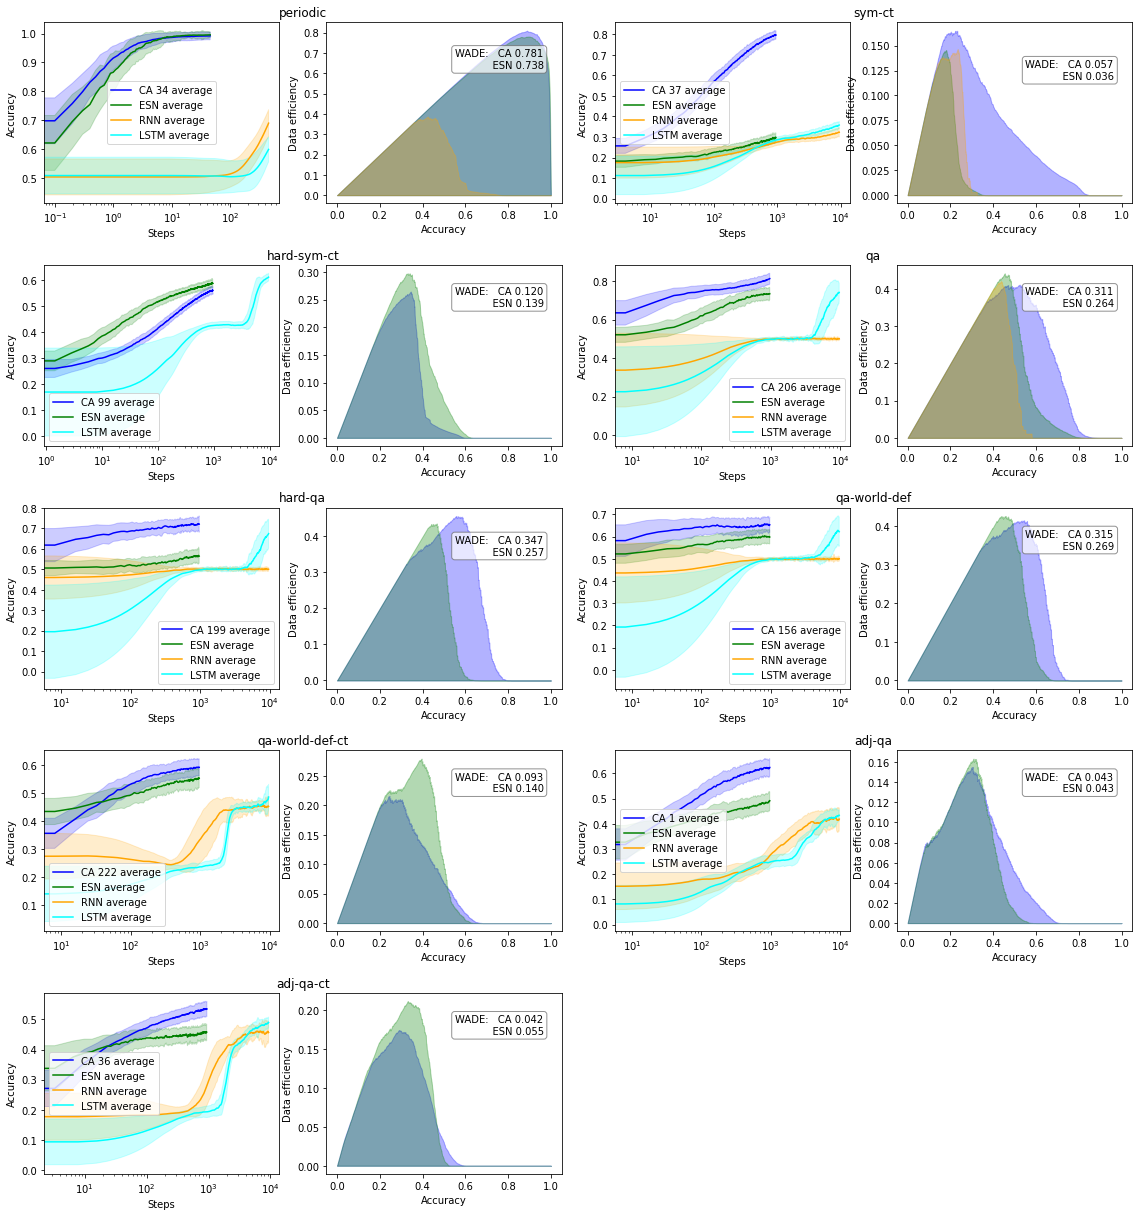

In [192]:
table = [
    "\\toprule",
    "& \\bfseries ReCA & \\bfseries ESN & \\bfseries RNN  & \\bfseries RNN $\\mathbf{\\times 10}$ & \\bfseries RNN $\\mathbf{\\times 100}$ \\\\",
    "\\midrule",
]

step = 0.001
weight = 1
speed = True
# fig, ax = plt.subplots(4, 4, figsize=(15, 15))
ls = [
    "periodic",
    "inc-per",
    "sym-ct",
    "hard-sym-ct",
    "qa",
    "hard-qa",
    "qa-world-def",
    "qa-world-def-ct",
    "adj-qa",
    "adj-qa-ct",
]
ls = [
    "periodic",
    "sym-ct",
    "hard-sym-ct",
    "qa",
    "hard-qa",
    "qa-world-def",
    "qa-world-def-ct",
    "adj-qa",
    "adj-qa-ct",
]

fig = plt.figure(figsize=(16, 17))

### Prepare a matplotlib grid with the right size
gs0 = gridspec.GridSpec(len(ls) // 2 + len(ls) % 2, 2, figure=fig)

batch_size = 8
c = 0
for name in ls:
    print(name)
    output_size = ID_TO_TASK[NAME_TO_ID[name]]().get_true_output_size()
    output_size = np.inf
    n_items_per_seq = ID_TO_TASK[NAME_TO_ID[name]]().get_n_items_per_seq()

    s = result_dict[name]
    sorted_rules = np.argsort(
        [max([max(i) for i in s[k]]) for k in range(256) if k in s]
    )
    print("Max", sorted_rules[:10], sorted_rules[-10:])

    sorted_rules = np.argsort(
        [np.mean([max(i) for i in s[k]]) for k in range(256) if k in s]
    )
    print("Average", sorted_rules[:10], sorted_rules[-10:])
    rule = sorted_rules[-1]

    ###### Rules sorted by TTO
    all_ttos = [
        (
            r,
            get_ttos(
                r,
                s,
                speed=speed,
                output_size=output_size,
                factor=n_items_per_seq / batch_size,
            ).max(),
        )
        for r in range(-2, 256)
        if r in s
    ]
    sorted_rules = [i[0] for i in sorted(all_ttos, key=lambda x: x[1])]
    print("TTO", sorted_rules[:10], sorted_rules[-10:])

    ###### ReCA TTO score
    r_tto = get_ttos(
        rule,
        s,
        speed=speed,
        output_size=output_size,
        factor=n_items_per_seq / batch_size,
    ).mean()
    t_reca = min(len(k) for k in s[rule])
    tasks[name]["ReCA"] = np.array([k[:t_reca] for k in s[rule]])
    print(rule, r_tto)

    ###### Echo state network TTO score
    esn_tto = 0
    if -1 in s:
        esn_tto = get_ttos(
            -1,
            s,
            speed=speed,
            output_size=output_size,
            factor=n_items_per_seq / batch_size,
        ).mean()
        t = min(len(k) for k in s[-1])
        tasks[name]["ESN"] = np.array([k[:t] for k in s[-1]])
    print("ESN", esn_tto)

    ###### RNN TTO score
    rnn_tto = {}
    for k in [-2, -20, -200, -3, -30]:
        if k in s:
            rnn_tto[k] = get_ttos(k, s, speed=speed, output_size=output_size).mean()
            t = min(len(p) for p in s[k])
            tasks[name][f"RNN{k}"] = np.array([p[:t] for p in s[k]])
            print(f"RNN{k}", rnn_tto[k])

    v = 5 * [""]
    vals = [
        r_tto,
        esn_tto,
        rnn_tto.get(-2, 0),
        rnn_tto.get(-20, 0),
        rnn_tto.get(-200, 0),
    ]
    v[np.argmax(vals)] = "\\bfseries"

    table.append(
        f"\\bfseries {name} & {v[0]} {r_tto:.3f} ({rule}) & {v[1]} {esn_tto:.3f} & "
        f"{v[2]} {rnn_tto.get(-2, 0):.3f} & {v[3]} {rnn_tto.get(-20, 0):.3f} & {v[4]} {rnn_tto.get(-200, 0):.3f} \\\\"
    )
    print("\n\n")

    ax_x = c // 4
    ax_y = c % 4
    # plt.plot(s[rule][-1])
    gssub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[c])
    ax0 = fig.add_subplot(gssub[0])
    ax1 = fig.add_subplot(gssub[1])

    ax_right = fig.add_subplot(gssub[:])
    ax_right.axis("off")
    ax_right.set_title(name)
    # ======================== Plot learning curves =====================

    ###### Plot ReCA curve
    base = tasks[name]["ReCA"]
    x_axis = np.linspace(0, len(base[0]) * batch_size / n_items_per_seq, len(base[0]))
    ax0.fill_between(
        x_axis,
        base.mean(0) - base.std(0),
        base.mean(0) + base.std(0),
        alpha=0.2,
        color="blue",
    )
    ax0.plot(x_axis, base.mean(0), label=f"CA {rule} average", color="blue")

    ###### Plot ESN curve
    if -1 in s:
        base = tasks[name]["ESN"]
        x_axis = np.linspace(
            0, len(base[0]) * batch_size / n_items_per_seq, len(base[0])
        )
        ax0.fill_between(
            x_axis,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color="green",
        )
        ax0.plot(x_axis, base.mean(0), label="ESN average", color="green")

    ###### Plot RNN curve
    if "RNN-2" in tasks[name]:
        base = tasks[name]["RNN-2"]
        x_axis_rnn = np.linspace(0, x_axis.max() * 10, len(base[0]))
        ax0.fill_between(
            x_axis_rnn,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color="orange",
        )
        ax0.plot(x_axis_rnn, base.mean(0), label="RNN average", color="orange")

    ###### Plot LSTM curve
    if "RNN-3" in tasks[name]:
        base = tasks[name]["RNN-3"]
        x_axis_lstm = np.linspace(0, x_axis.max() * 10, len(base[0]))
        ax0.fill_between(
            x_axis_lstm,
            base.mean(0) - base.std(0),
            base.mean(0) + base.std(0),
            alpha=0.2,
            color="cyan",
        )
        ax0.plot(x_axis_lstm, base.mean(0), label="LSTM average", color="cyan")

    ax0.set_xscale("log")

    res_ttos, rg = get_ttos(
        rule,
        s,
        do_sum=False,
        step=step,
        weight=weight,
        speed=speed,
        output_size=output_size,
        factor=n_items_per_seq,
    )
    # ax1.bar(x=rg + step/6, height=res_ttos.mean(1),
    #           width=1 * step/3, color="blue")
    ax1.fill_between(
        rg, np.zeros_like(res_ttos.mean(1)), res_ttos.mean(1), color="blue", alpha=0.3
    )

    if -1 in s:
        rnn_ttos, rg = get_ttos(
            -1,
            s,
            do_sum=False,
            step=step,
            weight=weight,
            speed=speed,
            output_size=output_size,
            factor=n_items_per_seq,
        )
        # ax1.bar(x=rg - step/6, height=rnn_ttos.mean(1),
        #          width=1 * step/3, color="green")
        ax1.fill_between(
            rg,
            np.zeros_like(rnn_ttos.mean(1)),
            rnn_ttos.mean(1),
            color="green",
            alpha=0.3,
        )

    if -20 in s:
        rnn_bs_ttos, rg = get_ttos(
            -20,
            s,
            do_sum=False,
            step=step,
            weight=weight,
            speed=speed,
            output_size=output_size,
        )
        # ax1.bar(x=rg - step/6, height=rnn_ttos.mean(1),
        #          width=1 * step/3, color="green")
        ax1.fill_between(
            rg,
            np.zeros_like(rnn_bs_ttos.mean(1)),
            rnn_bs_ttos.mean(1),
            color="orange",
            alpha=0.3,
        )

    choice = base[np.random.choice(range(len(base)))]
    ax1.set_xlabel("Accuracy")
    ax1.set_ylabel("Data efficiency")
    ax0.set_xlabel("Steps")
    ax0.set_ylabel("Accuracy")
    # plt.plot(choice, color="green", alpha=0.2) # , label="ESN - random run"
    # plt.plot(np.maximum.accumulate(choice), color="green", label=f"ESN - random run (+max)")
    # plt.plot(s[-1][np.argmax(get_ttos(-1, s))], color="darkgreen", label=f"ESN - best run TTO")
    # base = get_data(-2, s)
    # plt.fill_between(range(len(base[0])), base.mean(0) - base.std(0), base.mean(0) + base.std(0), alpha=0.3)
    # plt.plot(base.mean(0), label="RNN average")

    # plt.plot(base[np.random.choice(range(len(base)))], label=f"RNN - random run", color="red")
    if -1 in s:
        ax1.text(
            0.55,
            rnn_ttos.mean(1).max()
            - 0.2 * (rnn_ttos.mean(1).max() - rnn_ttos.mean(1).min()),
            f"WADE:   CA {r_tto:.3f}\n            ESN {esn_tto:.3f}",
            bbox=dict(
                boxstyle="round", fc=(1.0, 1.0, 1.0, 0.7), ec=(0.4, 0.4, 0.4, 0.7), lw=1
            ),
        )
    ax0.legend()

    c += 1
gs0.tight_layout(fig)
plt.show()

table.append("\\bottomrule")
fig.savefig("/Users/hugo/Work/papers/collas2022/figures/all_metrics.pdf")